In [1]:
from pathlib import Path
from typing import Dict, Tuple, Iterable, Optional, List
import json
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

RUNS_DIR = Path("/data/scastedo/runs_jan30_huge_modes")

def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Optional[Iterable[float]] = None,
    rin_values: Optional[Iterable[float]] = None,
    eta_values: Optional[Iterable[float]] = None,
    temp_values: Optional[Iterable[float]] = None,
    sigma_theta_values: Optional[Iterable[float]] = None,
    idir_values: Optional[Iterable[float]] = None,
    trials: Optional[Iterable[int]] = None,
    threshold_active_fraction_values: Optional[Iterable[float]] = None,
    I_str_values: Optional[Iterable[float]] = None,
    I_sigma_values: Optional[Iterable[float]] = None,
    strict: bool = True,
    tol: float = 1e-12,
) -> Tuple[
    Dict[Tuple[float, float, float, float, float], np.ndarray],
    List[float],
    List[float],
    List[float],
    List[float],
    List[float],
    List[float],
    List[int],
    int,
    List[float],
    List[float],
    List[float],
]:
    """Load run metadata and state histories into tensors.

    Returns tensors keyed by (ampar, rin, sigma_temp, sigma_eta, sigma_theta)
    plus parameter axes and network parameter values from metadata.
    """
    def sorted_unique(values: Iterable[float]) -> List[float]:
        return sorted({v for v in values if v is not None})

    def in_allowed(value, allowed: Optional[Iterable[float]]) -> bool:
        if allowed is None:
            return True
        if value is None:
            return False
        if isinstance(value, (float, int)):
            return any(math.isclose(float(value), float(v), rel_tol=tol, abs_tol=tol) for v in allowed)
        return value in allowed

    def load_state_matrix(folder: Path) -> np.ndarray:
        history_file = folder / "state_history.npy"
        if not history_file.exists():
            raise FileNotFoundError(f"Missing state history file: {history_file}")
        states = np.load(history_file)  # generations x neurons
        if states.ndim != 2:
            raise ValueError(f"Expected 2-D array in {history_file}, got {states.shape}")
        return states.T  # neurons x generations

    meta_paths = sorted(runs_dir.glob("*/run_metadata.json"))
    if not meta_paths:
        raise FileNotFoundError(f"No run_metadata.json found under {runs_dir}")

    metas = [(p.parent, json.loads(p.read_text())) for p in meta_paths]
    specs = [m.get("spec", {}) for _, m in metas]
    net_params = [m.get("network_params", {}) for _, m in metas]

    if ampar_values is None:
        ampar_values = sorted_unique(s.get("ampar") for s in specs)
    else:
        ampar_values = list(ampar_values)
    if rin_values is None:
        rin_values = sorted_unique(s.get("rin") for s in specs)
    else:
        rin_values = list(rin_values)
    if eta_values is None:
        eta_values = sorted_unique(s.get("sigma_eta") for s in specs)
    else:
        eta_values = list(eta_values)
    if temp_values is None:
        temp_values = sorted_unique(s.get("sigma_temp") for s in specs)
    else:
        temp_values = list(temp_values)
    if sigma_theta_values is None:
        sigma_theta_values = sorted_unique(s.get("sigma_theta") for s in specs)
    else:
        sigma_theta_values = list(sigma_theta_values)
    if idir_values is None:
        idir_values = sorted_unique(s.get("idir") for s in specs)
    else:
        idir_values = list(idir_values)
    if trials is None:
        trials = sorted_unique(s.get("trial") for s in specs)
    else:
        trials = list(trials)

    if threshold_active_fraction_values is None:
        threshold_active_fraction_values = sorted_unique(
            p.get("threshold_active_fraction") for p in net_params
        )
        threshold_active_fraction_filter = None
    else:
        threshold_active_fraction_filter = list(threshold_active_fraction_values)
        threshold_active_fraction_values = threshold_active_fraction_filter
    if I_str_values is None:
        I_str_values = sorted_unique(p.get("I_str") for p in net_params)
        I_str_filter = None
    else:
        I_str_filter = list(I_str_values)
        I_str_values = I_str_filter
    if I_sigma_values is None:
        I_sigma_values = sorted_unique(p.get("sigma_input") for p in net_params)
        I_sigma_filter = None
    else:
        I_sigma_filter = list(I_sigma_values)
        I_sigma_values = I_sigma_filter

    _block_sizes = sorted_unique(s.get("block_size") for s in specs)
    BLOCK_SIZE = _block_sizes[0] if _block_sizes else 1
    if len(_block_sizes) > 1:
        print(f"Note: multiple block_size values found: {_block_sizes}")

    runs_by_key: Dict[Tuple[float, float, float, float, float], Dict[Tuple[float, int], Path]] = {}

    for run_dir, meta in metas:
        spec = meta.get("spec", {})
        net = meta.get("network_params", {})
        ampar = spec.get("ampar")
        rin = spec.get("rin")
        sigma_temp = spec.get("sigma_temp")
        sigma_eta = spec.get("sigma_eta")
        sigma_theta = spec.get("sigma_theta")
        idir = spec.get("idir")
        trial = spec.get("trial")
        threshold_active_fraction = net.get("threshold_active_fraction")
        I_str = net.get("I_str")
        I_sigma = net.get("sigma_input")

        if None in (ampar, rin, sigma_temp, sigma_eta, sigma_theta, idir, trial):
            continue

        if not in_allowed(ampar, ampar_values):
            continue
        if not in_allowed(rin, rin_values):
            continue
        if not in_allowed(sigma_temp, temp_values):
            continue
        if not in_allowed(sigma_eta, eta_values):
            continue
        if not in_allowed(sigma_theta, sigma_theta_values):
            continue
        if not in_allowed(idir, idir_values):
            continue
        if not in_allowed(trial, trials):
            continue
        if threshold_active_fraction_filter is not None and not in_allowed(threshold_active_fraction, threshold_active_fraction_filter):
            continue
        if I_str_filter is not None and not in_allowed(I_str, I_str_filter):
            continue
        if I_sigma_filter is not None and not in_allowed(I_sigma, I_sigma_filter):
            continue

        key = (ampar, rin, sigma_temp, sigma_eta, sigma_theta)
        runs_by_key.setdefault(key, {})[(idir, trial)] = run_dir

    tensors: Dict[Tuple[float, float, float, float, float], np.ndarray] = {}
    for key, mapping in runs_by_key.items():
        idir_blocks = []
        for idir in idir_values:
            trial_blocks = []
            for trial in trials:
                folder = mapping.get((idir, trial))
                if folder is None:
                    if strict:
                        raise KeyError(f"Missing run for key={key}, idir={idir}, trial={trial}")
                    continue
                trial_blocks.append(load_state_matrix(folder))
            if not trial_blocks:
                if strict:
                    raise KeyError(f"No trials found for key={key}, idir={idir}")
                continue
            trial_cube = np.stack(trial_blocks, axis=2)  # neurons x generations x trials
            idir_blocks.append(trial_cube)
        if not idir_blocks:
            if strict:
                raise KeyError(f"No idir blocks found for key={key}")
            continue
        tensors[key] = np.stack(idir_blocks, axis=3)  # neurons x generations x trials x idir

    if strict and not tensors:
        raise ValueError(f"No runs matched filters under {runs_dir}")

    return (
        tensors,
        ampar_values,
        rin_values,
        eta_values,
        temp_values,
        sigma_theta_values,
        idir_values,
        trials,
        BLOCK_SIZE,
        threshold_active_fraction_values,
        I_str_values,
        I_sigma_values,
    )


In [20]:
import math
import tempfile
from pathlib import Path
from typing import Mapping, Tuple, List, Optional, Any
import numpy as np
from numpy.lib.format import open_memmap
import os 


class LazyStateTensor:
    """
    Array-like lazy tensor:
    - state.shape works
    - state[...] loads only requested slice from disk
    - big slices can be memmap-backed (disk, not RAM)
    """
    def __init__(
        self,
        mapping: Mapping[Tuple[float, int], Path],
        idir_values: List[float],
        trials: List[int],
        strict: bool = True,
        mmap_mode: str = "r",
        out: str = "auto",                    # "auto" | "memmap" | "memory"
        out_threshold_bytes: int = 2_000_000_000,
        out_dir: Optional[Path] = None,
        dtype: Optional[np.dtype] = None,
        fill_value: Optional[float] = None,
    ):
        self._mapping = dict(mapping)
        self._idir_values = list(idir_values)
        self._trials = list(trials)
        self._strict = strict
        self._mmap_mode = mmap_mode
        self._out = out
        self._out_threshold_bytes = out_threshold_bytes
        self._out_dir = Path(out_dir) if out_dir else Path(tempfile.gettempdir()) / "lazy_state_tensor"
        self._out_dir.mkdir(parents=True, exist_ok=True)
        self._dtype = dtype
        self._fill_value = fill_value

        self._shape = self._infer_shape()
        if self._dtype is None:
            self._dtype = self._infer_dtype()
        if self._fill_value is None:
            self._fill_value = np.nan if np.issubdtype(self._dtype, np.floating) else 0

    def _load_state_matrix(self, folder: Path) -> np.ndarray:
        history_file = folder / "state_history.npy"
        if not history_file.exists():
            raise FileNotFoundError(f"Missing state history file: {history_file}")
        states = np.load(history_file, mmap_mode=self._mmap_mode)  # gens x neurons
        if states.ndim != 2:
            raise ValueError(f"Expected 2-D array in {history_file}, got {states.shape}")
        return states.T  # neurons x gens (memmap-backed view)

    def _infer_shape(self) -> Tuple[int, int, int, int]:
        if not self._mapping:
            raise ValueError("Empty mapping; cannot infer shape.")
        folder = next(iter(self._mapping.values()))
        states = self._load_state_matrix(folder)
        n, t = states.shape
        return (n, t, len(self._trials), len(self._idir_values))

    def _infer_dtype(self) -> np.dtype:
        folder = next(iter(self._mapping.values()))
        states = self._load_state_matrix(folder)
        return states.dtype

    @property
    def shape(self) -> Tuple[int, int, int, int]:
        return self._shape

    @property
    def dtype(self) -> np.dtype:
        return self._dtype

    def _normalize_index(self, idx: Any) -> Tuple[Any, Any, Any, Any]:
        if not isinstance(idx, tuple):
            idx = (idx,)
        if Ellipsis in idx:
            ell_pos = idx.index(Ellipsis)
            pre = idx[:ell_pos]
            post = idx[ell_pos + 1:]
            missing = 4 - (len(pre) + len(post))
            idx = pre + (slice(None),) * missing + post
        idx = idx + (slice(None),) * (4 - len(idx))
        if len(idx) != 4:
            raise IndexError("Index must have 4 dimensions.")
        return idx

    def _sel_len(self, sel: Any, size: int) -> Tuple[Any, int, bool]:
        if isinstance(sel, slice):
            rng = range(*sel.indices(size))
            return sel, len(rng), False
        if isinstance(sel, (int, np.integer)):
            i = int(sel)
            if i < 0:
                i += size
            if i < 0 or i >= size:
                raise IndexError("Index out of range.")
            return i, 1, True
        arr = np.array(sel, dtype=int)
        if arr.ndim != 1:
            raise IndexError("Index array must be 1-D.")
        arr = np.where(arr < 0, arr + size, arr)
        if np.any((arr < 0) | (arr >= size)):
            raise IndexError("Index out of range.")
        return arr, arr.size, False

    def _sel_to_list(self, sel: Any, size: int) -> List[int]:
        if isinstance(sel, slice):
            return list(range(*sel.indices(size)))
        if isinstance(sel, (int, np.integer)):
            i = int(sel)
            if i < 0:
                i += size
            if i < 0 or i >= size:
                raise IndexError("Index out of range.")
            return [i]
        arr = np.array(sel, dtype=int).tolist()
        out = []
        for i in arr:
            if i < 0:
                i += size
            if i < 0 or i >= size:
                raise IndexError("Index out of range.")
            out.append(i)
        return out

    def _alloc_out(self, shape: Tuple[int, ...]) -> np.ndarray:
        nbytes = int(np.prod(shape)) * np.dtype(self._dtype).itemsize
        use_memmap = (
            self._out == "memmap"
            or (self._out == "auto" and nbytes >= self._out_threshold_bytes)
        )
        if use_memmap:
            path = self._out_dir / f"slice_{os.getpid()}_{id(self)}.npy"
            out = open_memmap(path, mode="w+", dtype=self._dtype, shape=shape)
            out[:] = self._fill_value
            return out
        return np.full(shape, self._fill_value, dtype=self._dtype)

    def __getitem__(self, idx: Any) -> np.ndarray:
        idx0, idx1, idx2, idx3 = self._normalize_index(idx)
        n0, n1, n2, n3 = self._shape

        sel0, len0, squeeze0 = self._sel_len(idx0, n0)
        sel1, len1, squeeze1 = self._sel_len(idx1, n1)
        trial_idxs = self._sel_to_list(idx2, n2)
        idir_idxs = self._sel_to_list(idx3, n3)

        out = self._alloc_out((len0, len1, len(trial_idxs), len(idir_idxs)))

        for ti, trial_idx in enumerate(trial_idxs):
            trial_val = self._trials[trial_idx]
            for di, idir_idx in enumerate(idir_idxs):
                idir_val = self._idir_values[idir_idx]
                folder = self._mapping.get((idir_val, trial_val))
                if folder is None:
                    if self._strict:
                        raise KeyError(f"Missing run for idir={idir_val}, trial={trial_val}")
                    continue
                states = self._load_state_matrix(folder)
                block = states[sel0, sel1]

                # Ensure 2D for assignment
                if block.ndim == 0:
                    block = block.reshape((1, 1))
                elif block.ndim == 1:
                    if len0 == 1:
                        block = block.reshape((1, len1))
                    else:
                        block = block.reshape((len0, 1))

                out[:, :, ti, di] = block.astype(self._dtype, copy=False)

        squeeze_axes = []
        if squeeze0:
            squeeze_axes.append(0)
        if squeeze1:
            squeeze_axes.append(1)
        if isinstance(idx2, (int, np.integer)):
            squeeze_axes.append(2)
        if isinstance(idx3, (int, np.integer)):
            squeeze_axes.append(3)

        if squeeze_axes:
            out = np.squeeze(out, axis=tuple(squeeze_axes))

        return out


In [21]:
tensors, AMPAR_VALUES, RIN_VALUES, ETA_VALUES, TEMP_VALUES, SIG_THETA_VALUES, IDIR_VALUES, TRIAL_INDICES, BLOCK_SIZE, THRESH_ACTIVE_FRACTION_VALUES, I_STR_VALUES, I_SIGMA_VALUES = build_state_store()


In [8]:
tensors, AMPAR_VALUES, RIN_VALUES, ETA_VALUES, TEMP_VALUES, SIG_THETA_VALUES, IDIR_VALUES, TRIAL_INDICES, BLOCK_SIZE, THRESH_ACTIVE_FRACTION_VALUES, I_STR_VALUES, I_SIGMA_VALUES = build_state_tensors()


NameError: name 'build_state_tensors' is not defined

In [25]:
def compute_snrs(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    # State Shape ( neurons, generations, trials, idir )
    neurons, _, trials, idirs = state.shape
    trials = 1 
    snr_array = np.zeros((trials))
    for trial in range(trials):
        # sample state just once every block at half block size
        # sample_ids = np.arange(BLOCK_SIZE//2, state.shape[1], BLOCK_SIZE)
        # state = state[:, sample_ids, :, :]
        angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
        other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
        delta_mu = state[:, :, trial,angle].mean(axis=1) - state[:, :, trial,other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])

        snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
        snr_array[trial] = snr_1

    return snr_array

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    deltas, snrs = [], []
    snrs = np.zeros((idirs,len(TRIAL_INDICES)))
    deltas  = np.zeros((idirs))


    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    # for idir_i, idir_j in combinations(range(idirs), 2):
    #     delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
    #     deltas.append(delta_idir)
    #     snrs.append(compute_snrs(data_avg, idir_1=idir_values[idir_i], idir_2=idir_values[idir_j]))

    idir_i = 0.5
    for idir_j in range(idirs):
      
        delta_idir = abs(idir_values[idir_j] - idir_i)
        deltas[idir_j] = delta_idir
        snrs[idir_j,:] = compute_snrs(data_avg, idir_1=idir_i, idir_2=idir_values[idir_j])

    return deltas, snrs
neurons = tensors[1,1,TEMP_VALUES[0],ETA_VALUES[0],SIG_THETA_VALUES[0]].shape[0]
delta_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES)))
snr_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len(TRIAL_INDICES)))

delta_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES),  len(IDIR_VALUES)))
snr_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len(TRIAL_INDICES)))

WINDOW = 1 

for i, temp in enumerate(TEMP_VALUES):
    for j, eta in enumerate(ETA_VALUES):
        for k, sigma_theta in enumerate(SIG_THETA_VALUES):
            delta_final_fr[i,j,k,:], snr_final_fr[i,j,k,:,:] = compute_snr_per_delta(tensors[0.64,1.27,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)
            delta_final_ctr[i,j,k,:], snr_final_ctr[i,j,k,:,:] = compute_snr_per_delta(tensors[1,1,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)


In [152]:
print(snr_final_fr[0,0,0,:,:])

[[0.00000000e+00]
 [9.27965881e-02]
 [2.30364590e-01]
 [4.28297341e-01]
 [1.13779822e+00]
 [2.64780575e+00]
 [5.78542518e+00]
 [8.69931235e+00]
 [8.79796062e+01]
 [8.30683302e+02]]


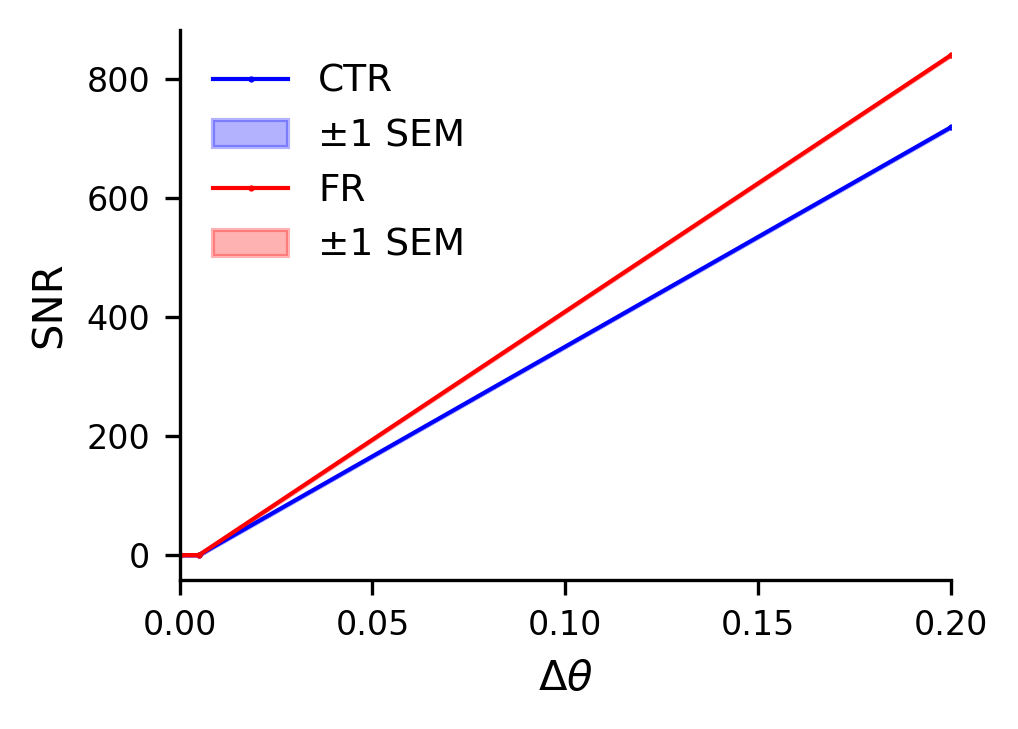

In [28]:
from matplotlib import pyplot as plt

def snr_to_performance(snrval):
    dprime = np.sqrt(snrval)
    z = dprime / np.sqrt(2)
    # perf = norm.cdf(z)
    # return perf
    return snrval

def plottings(x,y, label, color):
    mean_y = y.mean(axis=1)
    sem_y = y.std(axis=1, ddof=1) / np.sqrt(y.shape[1])

    # for trial_idx in range(y.shape[1]):
        # ax.plot(x, y[:, trial_idx], lw=0.5, alpha=0.3, color = color)

    # only plot first 5 angles
    mean_y = mean_y#[:7]
    sem_y = sem_y#[:7]
    x = x#[:7]
    ax.plot(x, mean_y, lw=1, marker='o', linestyle='-', label=label, color=color)
    ax.fill_between(x, mean_y - sem_y, mean_y + sem_y, alpha=0.3, label="±1 SEM", color=color)


fig, ax = plt.subplots(figsize=(3.5, 2.5))  # good size for 1-column figure
eta = ETA_VALUES[0]
temp = TEMP_VALUES[0]
sigma_theta = SIG_THETA_VALUES[0]

plottings(delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"CTR", color="blue")
plottings(delta_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"FR", color="red")
# ctr_vals = snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)])
# fr_vals = snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)])
# plt.plot(fr_vals/ctr_vals, label="FR/CTR", color="green")
# eta = ETA_VALUES[-1]
# temp = TEMP_VALUES[-1]
# sigma_theta = SIG_THETA_VALUES[-1]
# plottings(delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"CTR (no noise)", color="cyan")
# plottings(delta_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"FR (no noise)", color="magenta")
# plt.xlim(0,.12)
# plt.ylim(0,5000000)
# plt.ylim(0,10)
# plt.xlim(0,0.025)
# plt.ylim(0,500)
# plt.ylim(0,20)
# plt.yscale("log")
plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "lines.markersize": 0.5
})
# plt.xlim(0,0.05)
# plt.ylim(0,15)
ax.set_xlabel(r"$\Delta \theta$")
ax.set_ylabel("SNR")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# tighter x margins and layout
ax.margins(x=0)
ax.legend(frameon=False)
fig.tight_layout()
# ax.invert_xaxis()

In [154]:
ctr_results = snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)][:,0]
fr_results = snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)][:,0]
import pandas as pd
table = pd.DataFrame({
    "Delta Theta": delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)],
    "CTR SNR": ctr_results,
    "FR SNR": fr_results
})
print(table)

   Delta Theta     CTR SNR      FR SNR
0        0.000    0.000000    0.000000
1        0.005    0.152893    0.092797
2        0.010    0.232109    0.230365
3        0.015    0.455088    0.428297
4        0.020    1.320107    1.137798
5        0.030    2.795003    2.647806
6        0.040    6.224028    5.785425
7        0.050   10.260004    8.699312
8        0.100   99.058577   87.979606
9        0.200  850.002393  830.683302


# Per Mode SNR

In [23]:
TEMP = TEMP_VALUES[0]
ETA = ETA_VALUES[0]
SIG_THETA = SIG_THETA_VALUES[0]

def compute_snr_per_mode(state):
    neurons, generations, trials, idirs = state.shape
    overlaps_array = np.full((neurons,trials), np.nan)
    evals_array = np.full((neurons,trials), np.nan)
    main_dir = 0
    other_dir = 1
    for trial in range(trials):
        mean = state[:,:,trial,:].mean(axis=(1))  # neurons x idirs
        dmu = mean[:,main_dir] - mean[:,other_dir]
        covariance = np.cov(state[:,:,trial,main_dir])
        evals, evecs = np.linalg.eigh(covariance)
        order = np.argsort(evals)[::-1]
        evecs = evecs[:,order]
        evals = evals[order]
        for mode_idx in range(neurons):
            overlaps_array[mode_idx, trial] = (dmu @ evecs[:,mode_idx])**2 
            evals_array[mode_idx, trial] = evals[mode_idx]
        
    return overlaps_array[1:,:], evals_array[1:,:] 

import seaborn as sns


ctr_overlaps, ctr_evals = compute_snr_per_mode(tensors[1,1,TEMP,ETA,SIG_THETA])
fr_overlaps, fr_evals = compute_snr_per_mode(tensors[0.64,1.27,TEMP,ETA,SIG_THETA])

# sns.histplot(ctr_evals, stat='density', bins=30)


plt.plot(ctr_evals.mean(axis=1), ctr_overlaps.mean(axis=1), label="CTR", color="blue")
plt.plot(fr_evals.mean(axis=1), fr_overlaps.mean(axis=1), label="FR", color="red")

NameError: name 'plt' is not defined

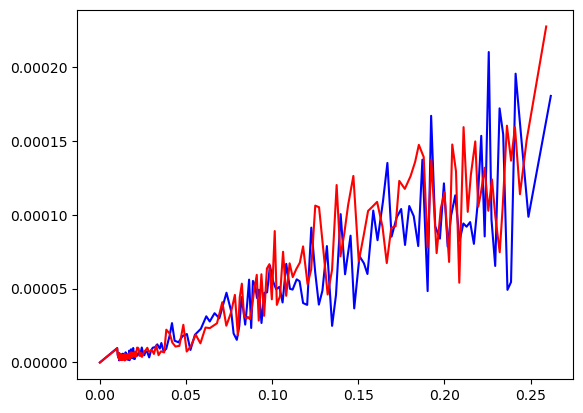

In [24]:
from matplotlib import pyplot as plt

plt.plot(ctr_evals.mean(axis=1), ctr_overlaps.mean(axis=1), label="CTR", color="blue")
plt.plot(fr_evals.mean(axis=1), fr_overlaps.mean(axis=1), label="FR", color="red")

## Verification of Covariance

In [170]:
def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))

    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile


def calculate_R_slow(state, N, T, Gen,ampar,rin):
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = 0.1
    equilibrium_change = BLOCK_SIZE

    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)

    R_matrices = np.zeros((Gen//equilibrium_change, N, N))
    for gen in range(Gen//equilibrium_change):
        start_gen = gen*equilibrium_change
        end_gen = (gen+1)*equilibrium_change
        mean_firing_rate = state[:, start_gen:end_gen].mean(axis=1)
        D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate)/T)
        R_matrices[gen,:,:] = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix*rin
    Mean_R_matrix = R_matrices.mean(axis=0)
    return Mean_R_matrix

def calculate_R_fast(state, N, T, ampar,rin):
    # STATE is N x GEn
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = THRESH_ACTIVE_FRACTION_VALUES[0]
    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)


    mean_firing_rate = state.mean(axis=1)
    D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate)) # DONT DIVIDE BY T HERE
    R_matrix = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix*rin
    return R_matrix

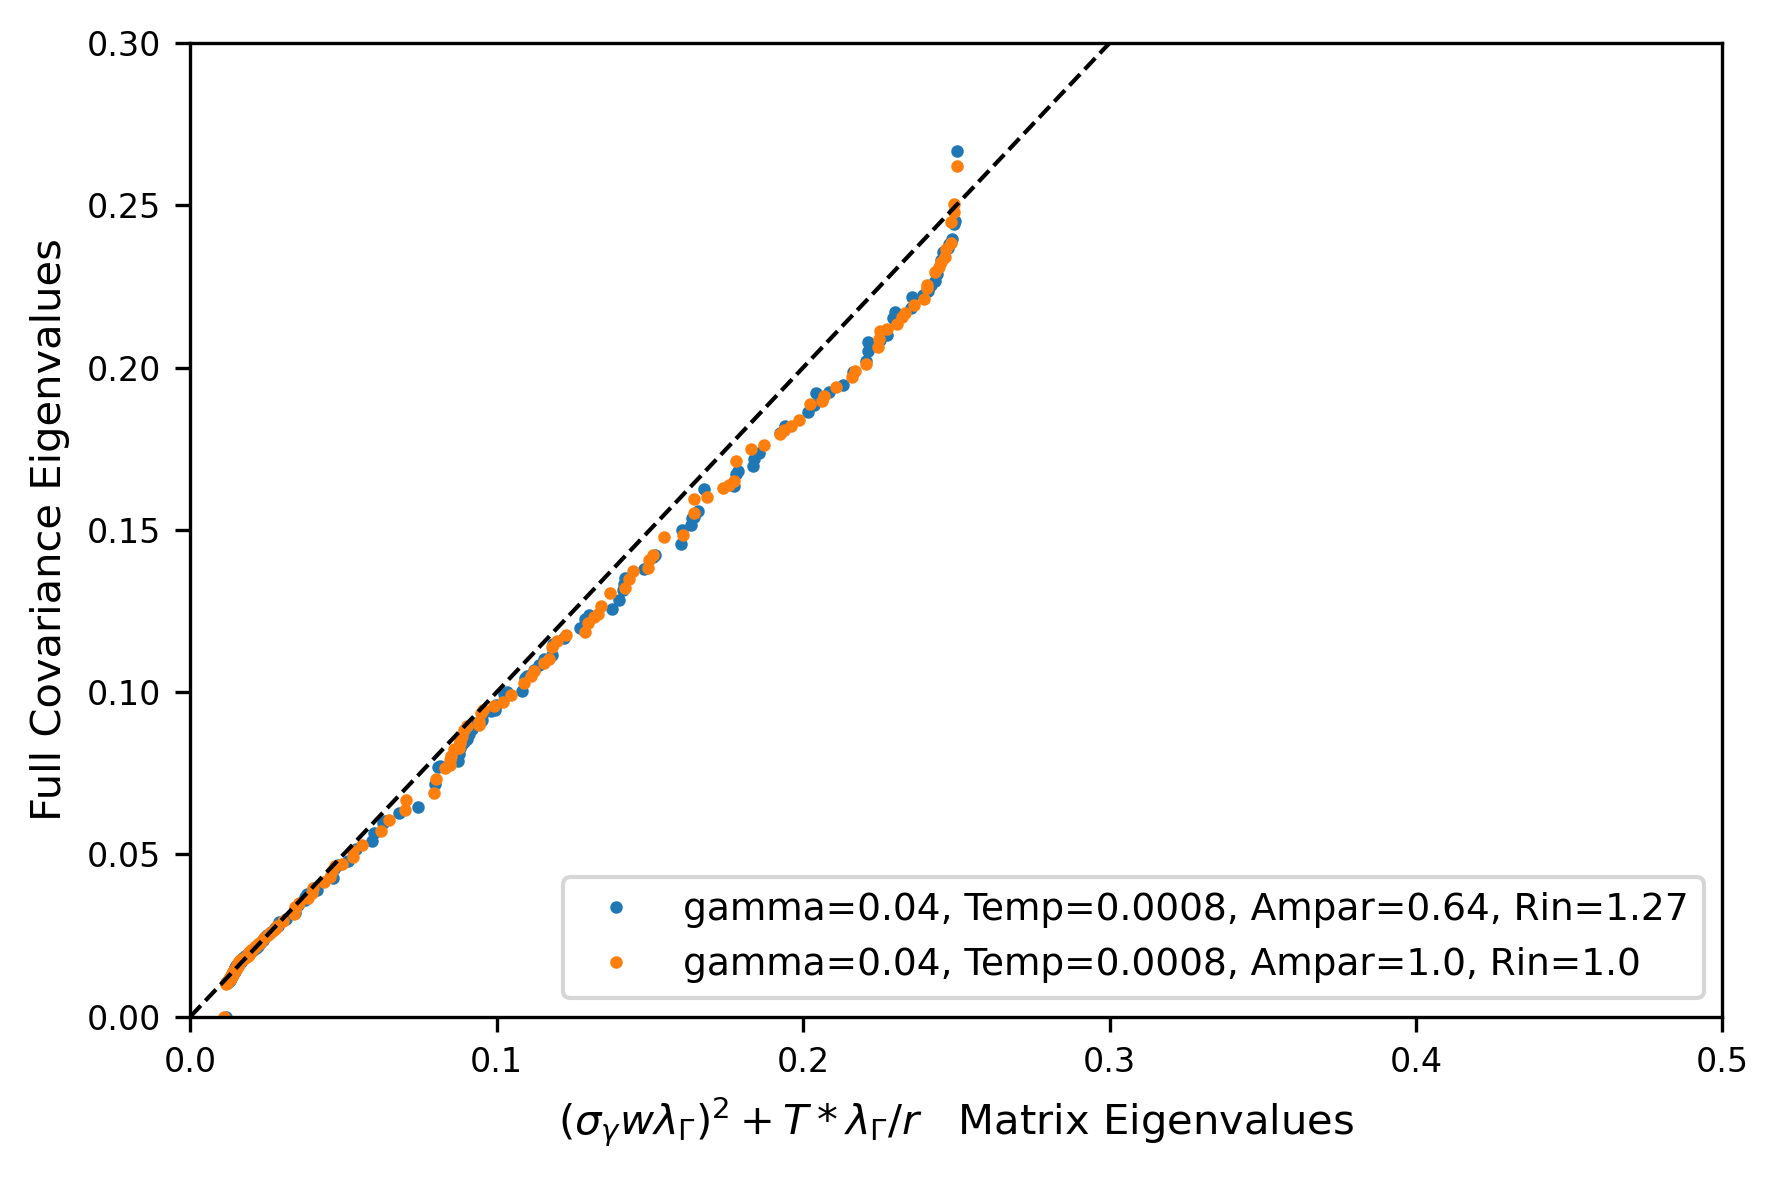

In [172]:
fig, ax = plt.subplots(figsize=(6, 4))
for AMPAR in AMPAR_VALUES:
    if AMPAR == 1.0:
        RIN = 1.0
    else:
        RIN = 1.27
    for TEMP in TEMP_VALUES[::-1]:
        for THETA in SIG_THETA_VALUES[::-1]:
            state_one_angle = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,0]
            Neurons, Generations, Trials = state_one_angle.shape
            state_one_angle = state_one_angle.reshape((Neurons, -1))

            covariance_full = np.cov(state_one_angle)
            eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

            # Define R matrix which is D(1-DJ)^-1 where D matrix is \partial(\sigma(h))/\partial h
            Mean_R_matrix = calculate_R_fast(state_one_angle, Neurons, TEMP, AMPAR, RIN)
            eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
            pred_full =  eigenvalues_r/RIN #+ (THETA*AMPAR*eigenvalues_r)**2
            ax.plot(pred_full,eigenvalues_full, 'o', markersize=2, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')

ax.plot([0, 0.3], [0, 0.3], 'k--', lw=1)
ax.set_ylabel("Full Covariance Eigenvalues")
ax.set_xlabel(r"($\sigma_\gamma w \lambda_\Gamma)^2 + T*\lambda_\Gamma/r$   Matrix Eigenvalues")
plt.xlim(0,0.5)
plt.ylim(0,0.3)
plt.legend()
fig.tight_layout()
plt.show()

# Verification of Signal Vector

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


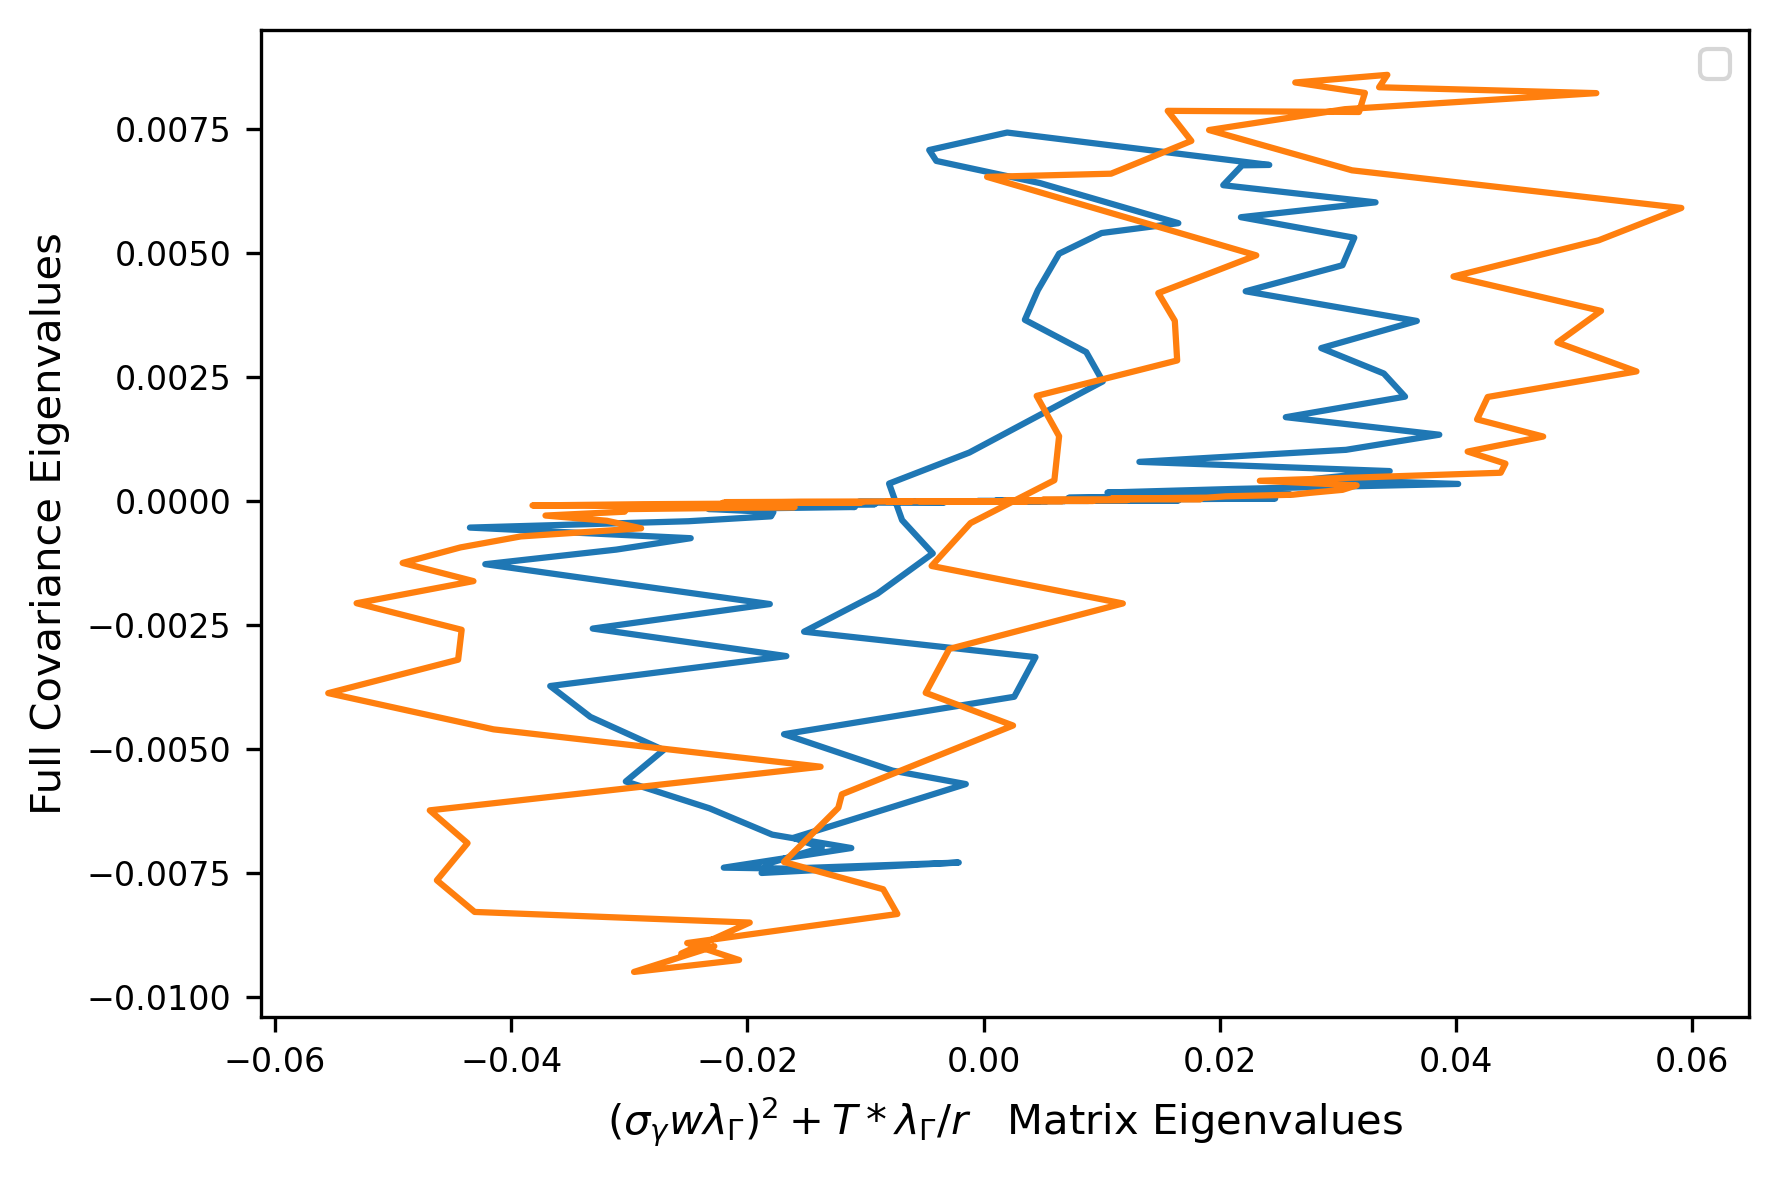

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
for AMPAR in AMPAR_VALUES:
    if AMPAR == 1.0:
        RIN = 1.0
    else:
        RIN = 1.27
    for TEMP in TEMP_VALUES[::-1]:
        for THETA in SIG_THETA_VALUES[::-1]:
            idir1 = 0 
            state1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].reshape((neurons, -1))
            mu1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].mean(axis=(1,2))

            linear_response = calculate_R_fast(state1, neurons, TEMP, AMPAR, RIN)
            idir2= 1
        # for idir2 in range(len(IDIR_VALUES)):
            if idir1 == idir2:
                continue
            mu2 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir2].mean(axis=(1,2))
            delta_mu = mu1 - mu2

            delta_x = get_bump(IDIR_VALUES[idir1], neurons, SIG_THETA, 1.0) - get_bump(IDIR_VALUES[idir2], neurons, SIG_THETA, 1.0)
            delta_mu_estimate = AMPAR*linear_response @ delta_x
            plt.plot(delta_mu, delta_mu_estimate)# label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}, idir2={IDIR_VALUES[idir2]}')
            # state_one_angle = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,0]
            # Neurons, Generations, Trials = state_one_angle.shape
            # state_one_angle = state_one_angle.reshape((Neurons, -1))

            # covariance_full = np.cov(state_one_angle)
            # eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

            # # Define R matrix which is D(1-DJ)^-1 where D matrix is \partial(\sigma(h))/\partial h
            # Mean_R_matrix = calculate_R_fast(state_one_angle, Neurons, TEMP, AMPAR, RIN)
            # eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
            # pred_full =  eigenvalues_r/RIN #+ (THETA*AMPAR*eigenvalues_r)**2
            # ax.plot(pred_full,eigenvalues_full, 'o', markersize=2, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')

# ax.plot([0, 0.3], [0, 0.3], 'k--', lw=1)
# plt.xlim(0,0.5)
# plt.ylim(0,0.3)
plt.legend()
fig.tight_layout()
plt.show()

(0.0, 10.0)

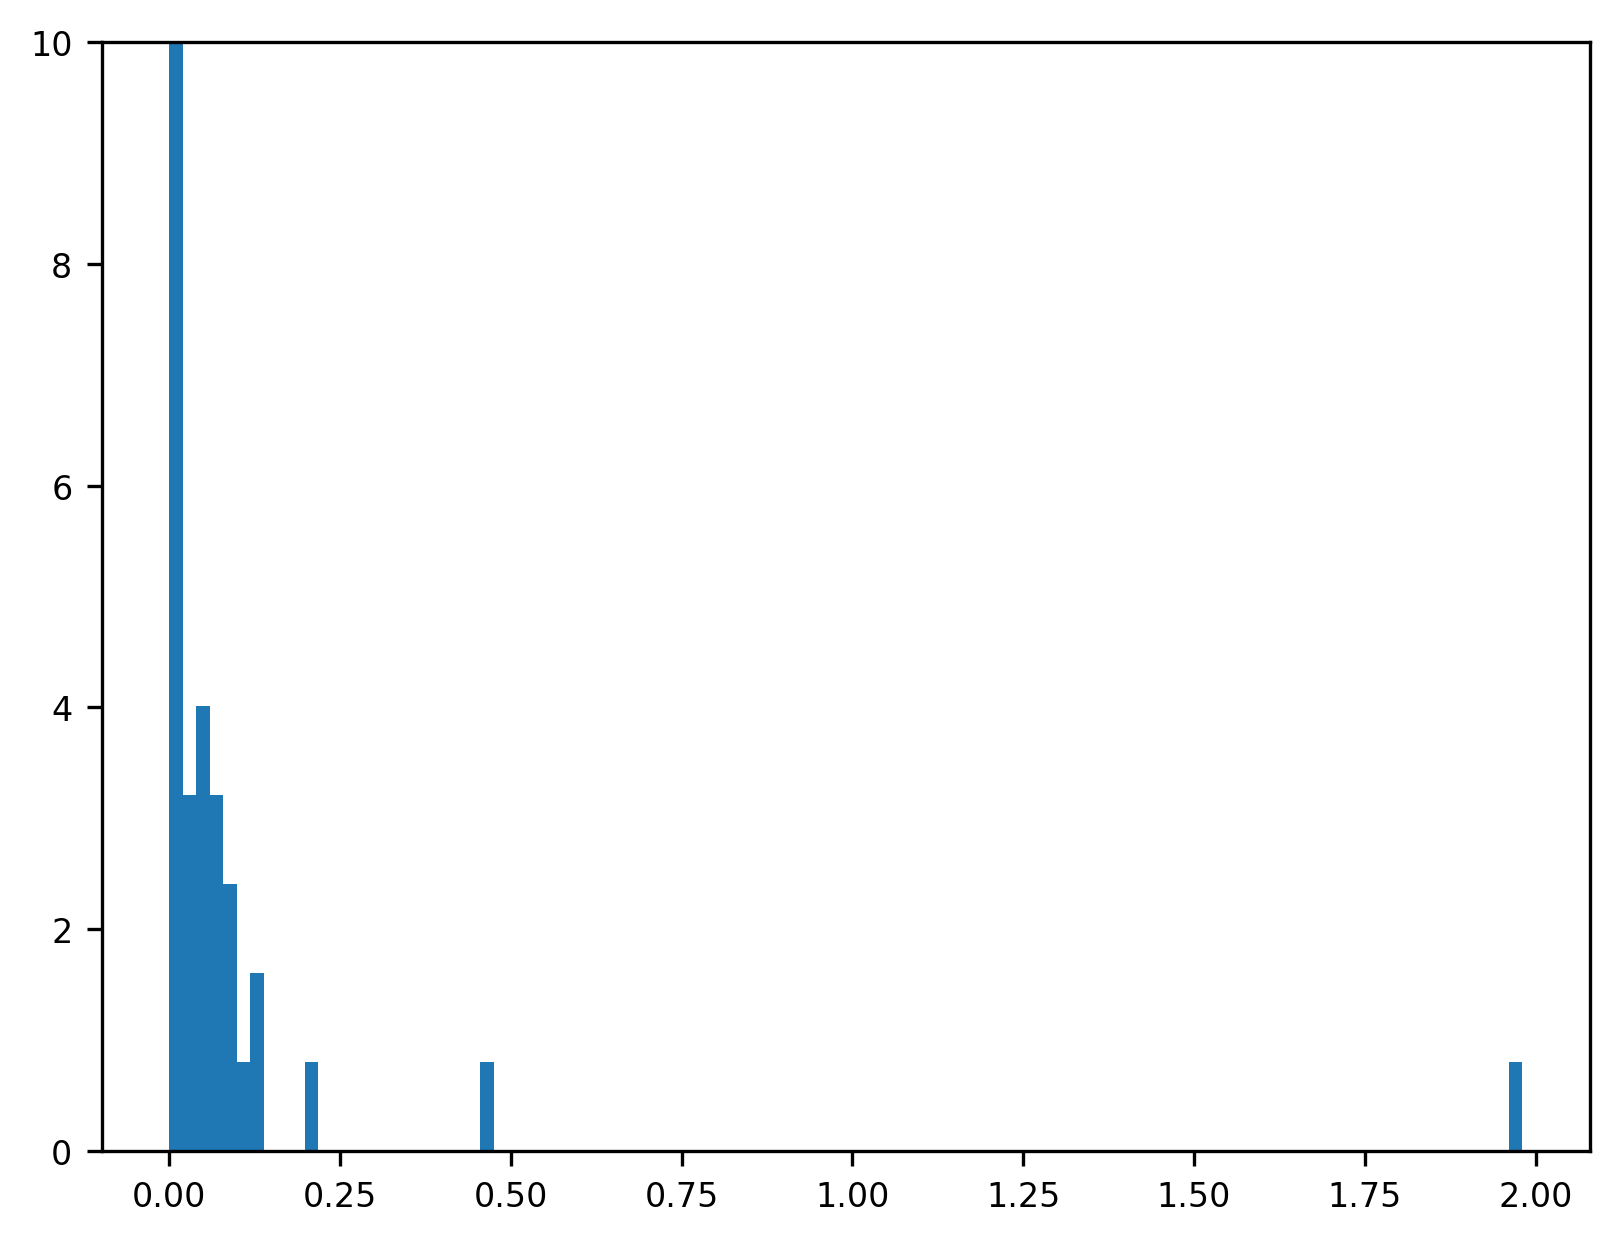

In [54]:
plt.hist(eigenvalues_full[eigenvalues_full > 0], bins=100, density=True)
plt.ylim(0,10)

In [25]:
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)-1):
    for TEMP in TEMP_VALUES[::-1]:
            for THETA in SIG_THETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA, THETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))
                
                # FULL COVARIANCE
                covariance_full = np.cov(state_one_angle)
                eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

                # CALCULATE DELTA MU AND SNR             
                mu1 = tensors[AMPAR, RIN, TEMP, ETA, THETA][:,:,:,idir].reshape((Neurons, -1)).mean(axis=1) 
                mu2 = state_one_angle.mean(axis=1)
                delta_mu = mu1 - mu2
                snr = delta_mu.T @ np.linalg.pinv(covariance_full) @ delta_mu


                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR, RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
                bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR* Mean_R_matrix @ delta_x_bump
                
                ## PREDICTIONS FOR SNR
                # overlap_term = eigenvalues_r**2 * (eigenvectors_r.T @ delta_x_bump)**2
                # cov_eval = ((ETA*eigenvalues_r/TEMP)**2 + eigenvalues_r)
                # snr_predicted_eigenvalues = np.sum(overlap_term/cov_eval)

                # predicted_covariance = AMPAR*(ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN**2 * AMPAR)
                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN)

                snr_predicted_eigenvalues = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                
                snr_actual[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr
                snr_predicted[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted_eigenvalues


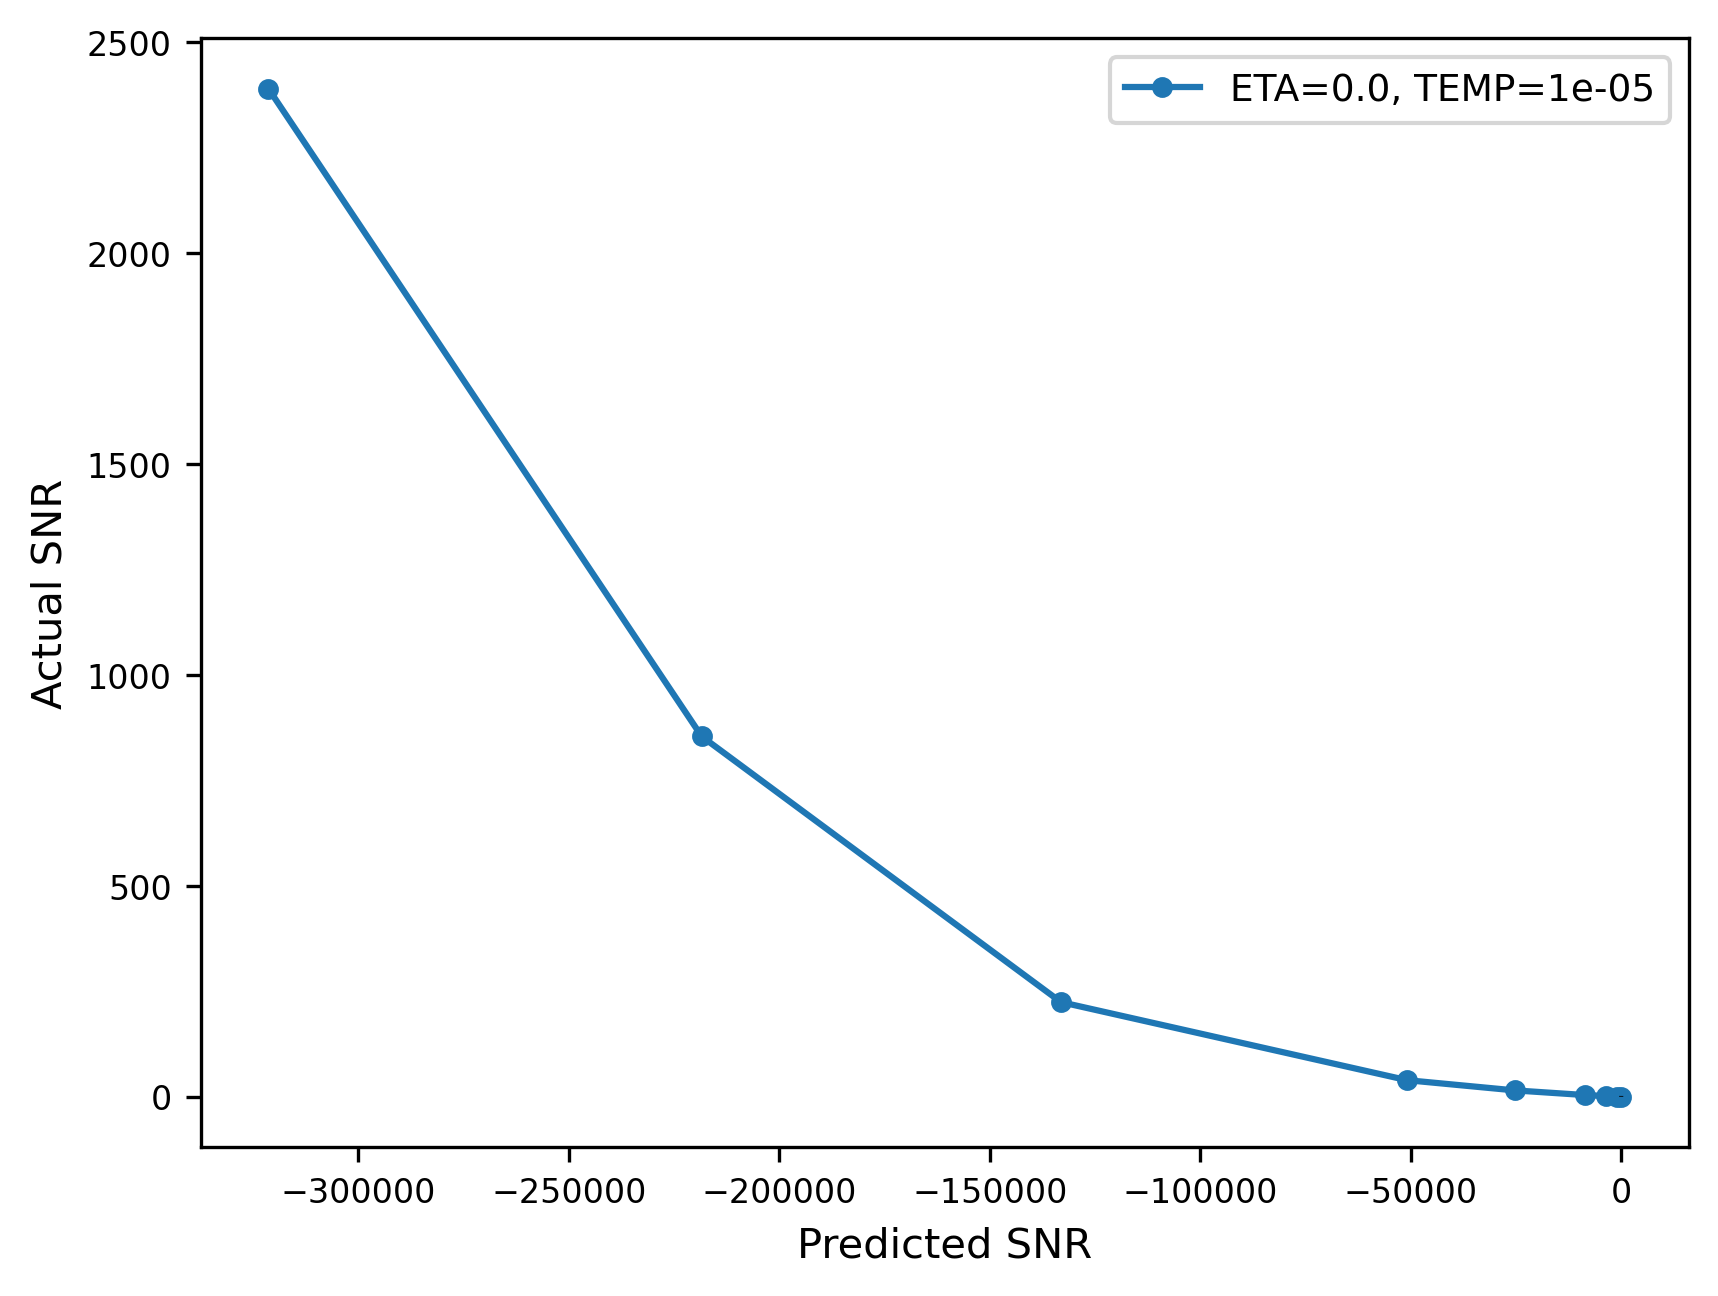

In [ ]:
max_idir = len(IDIR_VALUES)-2
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        # if temp==0.01 and eta==0.0:
        #     continue
        # if temp==0.01 and eta==0.04:
        #     continue
  
        plt.plot(snr_predicted[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), snr_actual[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")
plt.plot([0,2], [0,2], 'k--', lw=1  )
# plt.xlim(0,10)
# plt.ylim(0,10)
plt.legend()
plt.show()

In [26]:
# Checking effect of food restriction on SNR


AMPAR = 1.0
RIN = 1.0
Neurons = 500

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_CTR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU

                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_CTR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_FR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_FR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 500 is different from 100)

/tmp/ipykernel_3456/4066449938.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')


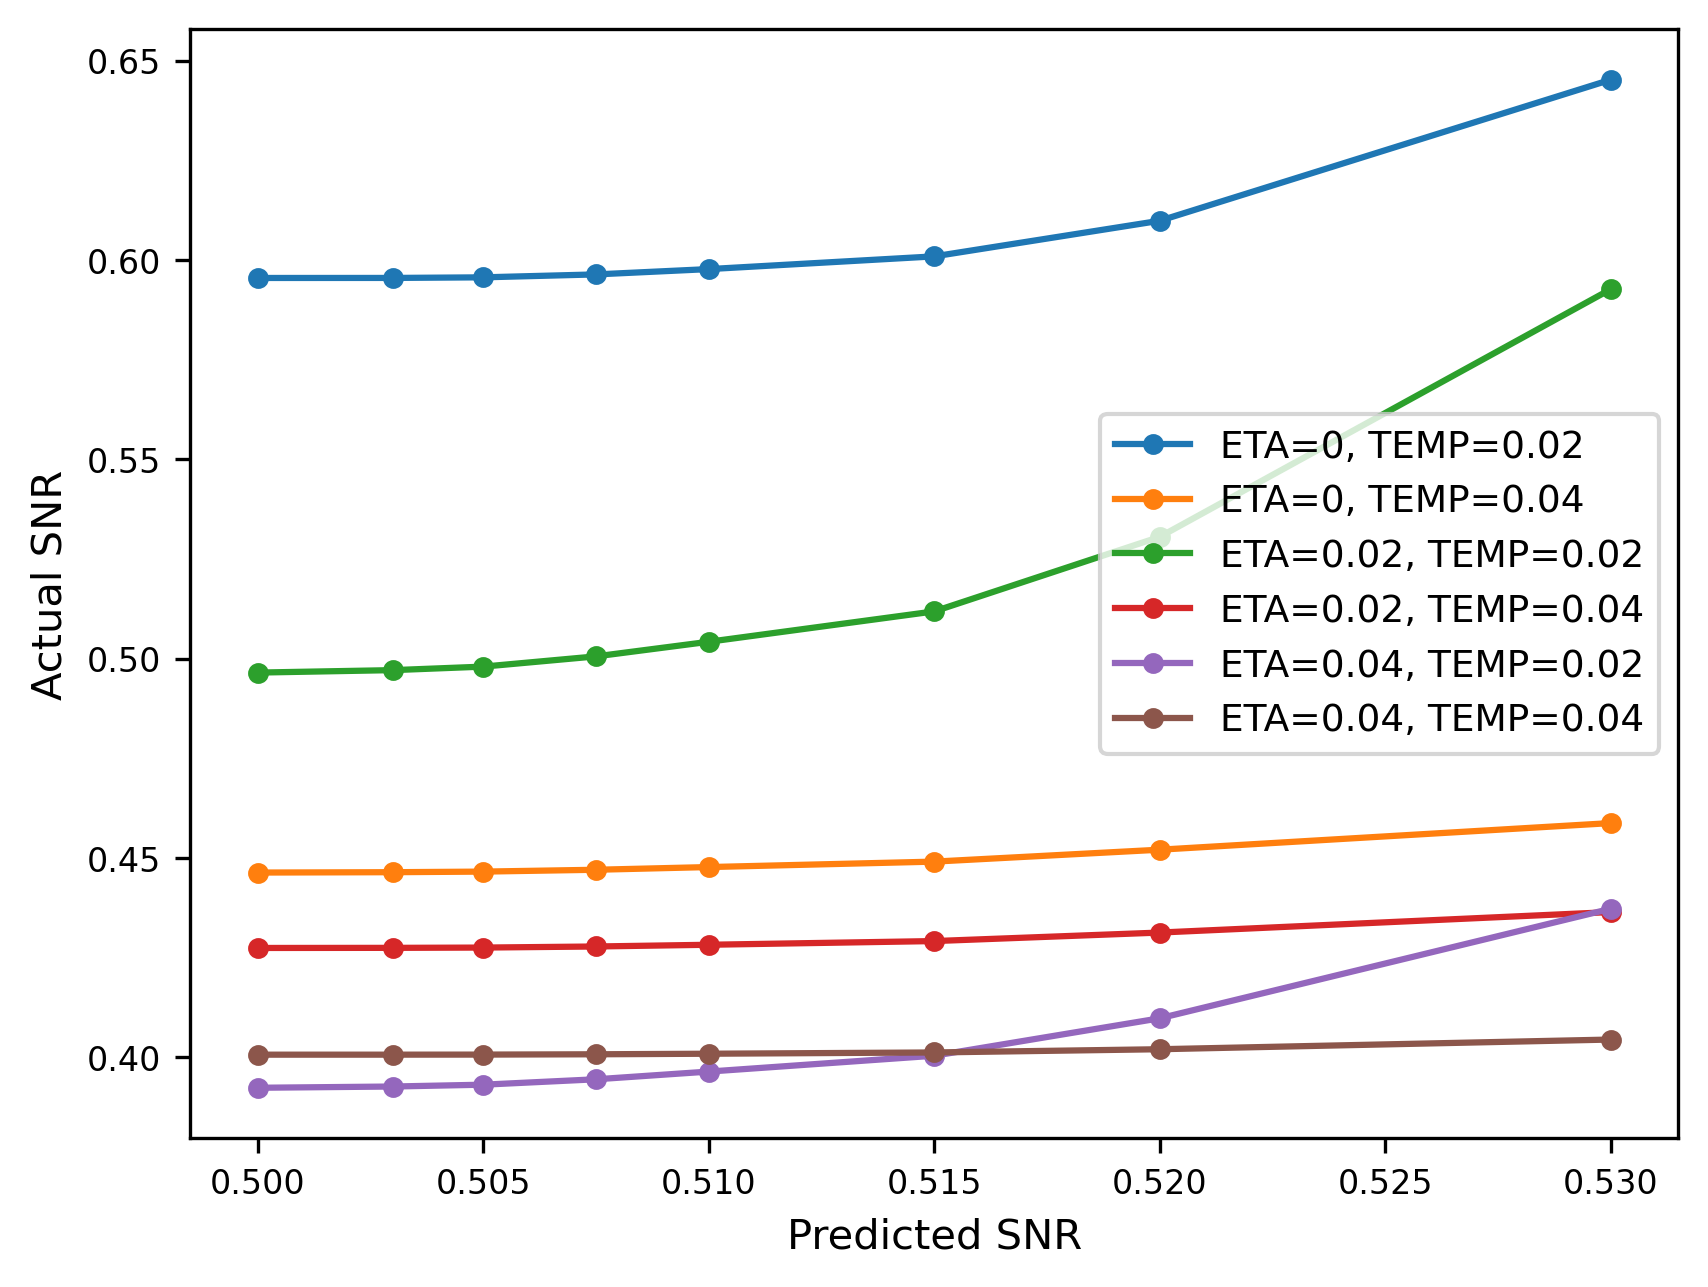

In [150]:
max_idir = len(IDIR_VALUES)
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")

plt.legend()
plt.show()

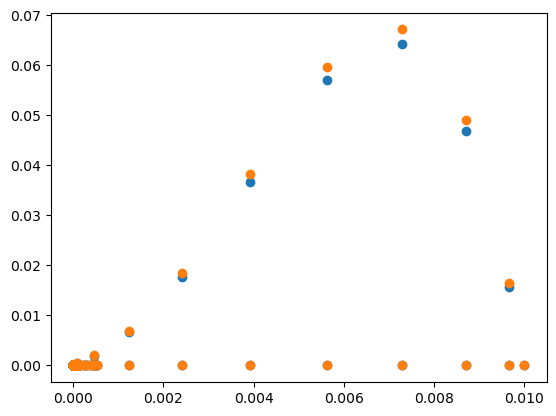

In [19]:
delta_x2 = 0.0001
sigma_x2 = 0.01
T = 0.001
sigma_eta2 = 0.
r = 1.27
w = 0.64


N=1000
threshold_active_fraction = 0.1
indices = np.arange(N)
i_matrix = indices[:, None]      # shape (N, 1)
j_matrix = indices[None, :]      # shape (1, N)
diff = np.abs(i_matrix - j_matrix)
diff = np.minimum(diff, N - diff)
threshold = threshold_active_fraction * N / 2.0
weights = (diff <= threshold).astype(float) / N
np.fill_diagonal(weights, 0.0)

# random_matrix  = np.random.randn(1000,1000)
# random_symmetric_matrix = (random_matrix + random_matrix.T)/2
eigenval, eigenvec = np.linalg.eigh(weights)
delta_x_bump = get_bump(0.504, N, 0.05, 0.1) - get_bump(0.5, N, 0.05, 0.1)

def info(eval):
    return (np.dot(delta_x_bump,eigenvec)**2)/(sigma_x2+sigma_eta2/(w**2)+(T*(1-r*w*eval))/((w*r)**2))



info1= info(eigenval)
r = 1
w = 1
info2 = info(eigenval)
plt.scatter(eigenval**2, info1)
plt.scatter(eigenval**2, info2)


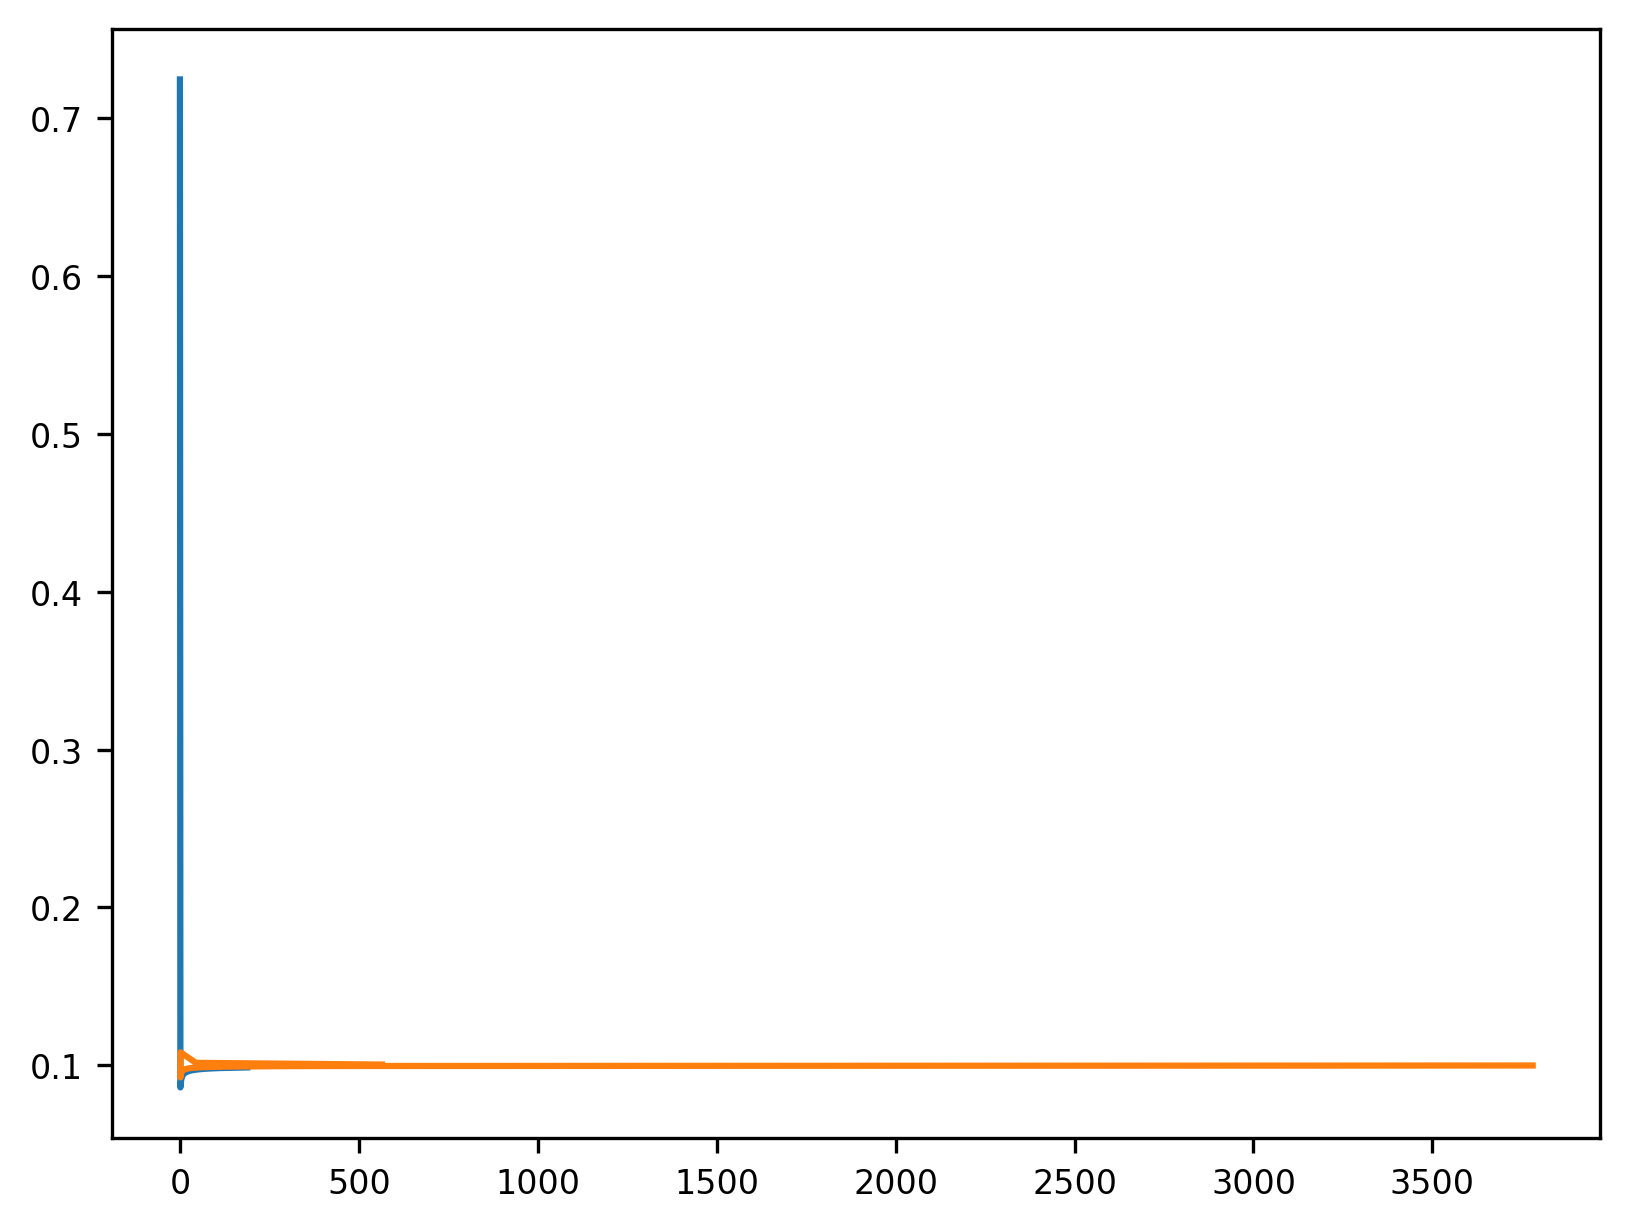

In [ ]:

def calculate_R(state, N, T, Gen,ampar,rin):
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = 0.1
    equilibrium_change = BLOCK_SIZE

    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)

    R_matrices = np.zeros((Gen//equilibrium_change, N, N))
    for gen in range(Gen//equilibrium_change):
        start_gen = gen*equilibrium_change
        end_gen = (gen+1)*equilibrium_change
        mean_firing_rate = state[:, start_gen:end_gen].mean(axis=1)
        D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate)/T)
        R_matrices[gen,:,:] = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix*rin
    Mean_R_matrix = R_matrices.mean(axis=0)
    return Mean_R_matrix

def info(eval):
    return delta_x2/(theta+eta/(ampar**2)+temp/(rin*eval*ampar**2))

def snrmat(rmat):
    numerator = delta_x2 * rmat 
    denominator = (theta + eta/(ampar**2)) * rmat @ rmat + temp/(rin*ampar**2) * rmat
    new_mat = numerator*np.linalg.pinv(denominator)*numerator
    return np.linalg.eigvalsh(new_mat)

    

delta_x2 = 0.001
sigma_x2 = 0.01

ampar  =0.64
rin  = 1.27
temp = 0.001
eta =0.00
theta = 0.01



rmatrix = calculate_R(tensors[ampar, rin,temp, eta, theta][:,:,:,0].reshape((400, -1)), 400, temp, 100000, ampar, rin)
eval1, evec = np.linalg.eigh(rmatrix)
info1 = info(eval1)
# snrinfo = snrmat(rmatrix)
plt.plot(eval1**2, info1)

ampar  =1
rin  = 1

rmatrix = calculate_R(tensors[ampar, rin,temp, eta, theta][:,:,:,0].reshape((400, -1)), 400, temp, 100000, ampar, rin)
eval2, evec = np.linalg.eigh(rmatrix)
# snrinfo2 = snrmat(rmatrix)
# plt.plot(eval2, snrinfo2)
plt.plot(eval2**2, info2)
plt.show()
# plt.bar([0,1],[np.sum(info1),np.sum(info2)])



In [35]:
import numpy as np
from typing import Tuple, Dict, Any

# -------------------------------
# Part A: pooled covariance + ridge
#         + top-eigenmode SNR + alignment
# -------------------------------

def _as_numpy(x):
    # Accept numpy arrays, python lists, or torch tensors
    if isinstance(x, np.ndarray):
        return x
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)


def block_average(state: np.ndarray, window_size: int) -> np.ndarray:
    """
    state: (neurons, generations, trials, idir)
    returns: (neurons, n_blocks, trials, idir) where n_blocks = generations // window_size
    """
    state = _as_numpy(state)
    if state.ndim != 4:
        raise ValueError(f"state must be 4D (neurons, generations, trials, idir), got shape {state.shape}")

    n_neurons, n_gen, n_trials, n_idir = state.shape
    if window_size <= 0:
        raise ValueError("window_size must be > 0")
    n_blocks = n_gen // window_size
    if n_blocks < 2:
        raise ValueError(f"Need at least 2 blocks for covariance. "
                         f"Got n_gen={n_gen}, window_size={window_size}, n_blocks={n_blocks}.")

    cut = n_blocks * window_size
    trimmed = state[:, :cut, :, :]  # (neurons, cut, trials, idir)
    reshaped = trimmed.reshape(n_neurons, n_blocks, window_size, n_trials, n_idir)
    return reshaped.mean(axis=2)    # average within each block


def _cov_time(X: np.ndarray) -> np.ndarray:
    """
    X: (neurons, T) samples across time/blocks
    returns: (neurons, neurons) covariance across time samples
    """
    return np.cov(X, bias=False)


def _ridge_cov(C: np.ndarray, ridge: float) -> np.ndarray:
    """
    Add scaled ridge to stabilize inversion.
    ridge is unitless; we scale by mean variance via trace/N.
    """
    n = C.shape[0]
    scale = float(np.trace(C) / max(n, 1))
    return C + (ridge * scale) * np.eye(n)


def fisher_snr_from_pooled_cov(X1: np.ndarray, X2: np.ndarray, ridge: float = 1e-3) -> float:
    """
    X1, X2: (neurons, T) block-averaged time samples for the two conditions
    Computes delta_mu^T (0.5(C1+C2)+ridgeI)^{-1} delta_mu
    """
    mu1 = X1.mean(axis=1)
    mu2 = X2.mean(axis=1)
    delta_mu = mu1 - mu2

    C1 = _cov_time(X1)
    C2 = _cov_time(X2)
    Cpool = 0.5 * (C1 + C2)
    Cpool = _ridge_cov(Cpool, ridge)

    return float(delta_mu.T @ np.linalg.solve(Cpool, delta_mu))


def top_mode_snr_and_alignment(X1: np.ndarray, X2: np.ndarray, ridge: float = 1e-6) -> Tuple[float, float]:
    """
    Returns:
      top_mode_snr = (v1^T delta_mu)^2 / lambda1
      alignment    = |cos(angle(delta_mu, v1))|
    computed using pooled covariance eigen-decomposition.
    """
    mu1 = X1.mean(axis=1)
    mu2 = X2.mean(axis=1)
    delta_mu = mu1 - mu2

    C1 = _cov_time(X1)
    C2 = _cov_time(X2)
    Cpool = 0.5 * (C1 + C2)
    Cpool = _ridge_cov(Cpool, ridge)

    evals, evecs = np.linalg.eigh(Cpool)  # ascending
    v1 = evecs[:, -1]
    lam1 = float(evals[-1])

    top_snr = float((v1 @ delta_mu) ** 2 / lam1)

    denom = (np.linalg.norm(delta_mu) * np.linalg.norm(v1) + 1e-12)
    align = float(abs((v1 @ delta_mu) / denom))
    return top_snr, align


def snr_vs_delta(
    state: np.ndarray,
    idir_values,
    ref_idir: float,
    window_size: int,
    ridge_fisher: float = 1e-3,
    ridge_eig: float = 1e-6,
) -> Dict[str, Any]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    ref_idir: reference angle/orientation in same units as idir_values
    """
    state = _as_numpy(state)
    idir_values = _as_numpy(idir_values).astype(float)

    data = block_average(state, window_size=window_size)  # (neurons, n_blocks, trials, idir)
    n_neurons, n_blocks, n_trials, n_idir = data.shape

    if idir_values.shape[0] != n_idir:
        raise ValueError(f"len(idir_values)={idir_values.shape[0]} does not match state idir dim={n_idir}")

    ref_idx = int(np.argmin(np.abs(idir_values - float(ref_idir))))

    deltas = np.zeros(n_idir, dtype=float)
    fisher = np.zeros((n_idir, n_trials), dtype=float)
    topmode = np.zeros((n_idir, n_trials), dtype=float)
    align = np.zeros((n_idir, n_trials), dtype=float)

    for j in range(n_idir):
        deltas[j] = float(abs(idir_values[j] - idir_values[ref_idx]))
        for tr in range(n_trials):
            Xref = data[:, :, tr, ref_idx]  # (neurons, n_blocks)
            Xj   = data[:, :, tr, j]

            fisher[j, tr] = fisher_snr_from_pooled_cov(Xref, Xj, ridge=ridge_fisher)
            topmode[j, tr], align[j, tr] = top_mode_snr_and_alignment(Xref, Xj, ridge=ridge_eig)

    return {"deltas": deltas, "fisher": fisher, "topmode": topmode, "align": align}


def run_part_A(
    tensor_ctr,
    tensor_fr,
    idir_values,
    ref_idir: float,
    window_size: int,
    ridge_fisher: float = 1e-3,
    ridge_eig: float = 1e-6,
):
    out_ctr = snr_vs_delta(tensor_ctr, idir_values, ref_idir, window_size, ridge_fisher, ridge_eig)
    out_fr  = snr_vs_delta(tensor_fr,  idir_values, ref_idir, window_size, ridge_fisher, ridge_eig)

    deltas = out_ctr["deltas"]
    order = np.argsort(deltas)

    print("Delta      Fisher_CTR   Fisher_FR    TopMode_CTR  TopMode_FR   Align_CTR   Align_FR")
    for idx in order:
        d = deltas[idx]
        fc = out_ctr["fisher"][idx].mean()
        ff = out_fr["fisher"][idx].mean()
        tc = out_ctr["topmode"][idx].mean()
        tf = out_fr["topmode"][idx].mean()
        ac = out_ctr["align"][idx].mean()
        af = out_fr["align"][idx].mean()
        print(f"{d:6.4f}   {fc:10.6f}  {ff:10.6f}   {tc:10.6f}  {tf:10.6f}   {ac:9.4f}  {af:9.4f}")

    return out_ctr, out_fr


# -------------------------------
# Example usage (your case)
# -------------------------------
ctr_state = tensors[1, 1, temp, eta, sigma_theta]          # (neurons, gen, trials, idir)
fr_state  = tensors[0.64, 1.27, temp, eta, sigma_theta]
out_ctr, out_fr = run_part_A(
    tensor_ctr=ctr_state,
    tensor_fr=fr_state,
    idir_values=IDIR_VALUES,   # can be list or np array now
    ref_idir=0.5,
    window_size=BLOCK_SIZE,
    ridge_fisher=1e-3,
    ridge_eig=1e-6,
)


Delta      Fisher_CTR   Fisher_FR    TopMode_CTR  TopMode_FR   Align_CTR   Align_FR
0.0000     0.000000    0.000000     0.000000    0.000000      0.0000     0.0000
0.0025     0.000000    0.000000     0.000000    0.000000      0.0000     0.0000
0.0050     0.045349    0.072867     0.003461    0.021526      0.8325     0.9532
0.0100     0.078437    0.160128     0.018791    0.094163      0.9544     0.9859
0.0150     0.204704    0.248319     0.136103    0.167607      0.9919     0.9919
0.0200     0.556235    0.577233     0.454192    0.472913      0.9956     0.9959
0.0300     1.090002    1.037888     0.937297    0.920565      0.9968     0.9977
0.0500     3.410656    2.509120     3.146889    2.328786      0.9974     0.9975
0.0750     9.800128    6.446382     8.186079    5.726227      0.9901     0.9936
0.1000    26.133804   15.084112    16.287871   11.819449      0.9619     0.9704
0.2000   508.612968  126.458312     0.016759    0.008129      0.0233     0.0185
